# Feature engineering

En este notebook realizaremos tareas propias del feature engineering. En particular, trataremos de estudiar la importancia de las variables para decidir si hay alguna variable que podamos eliminar porque no aporta ninguna información relevante al modelo, e intentaremos crear variables nuevas a partir del análisis realizado en el notebook *Data_Exploration*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data = pd.read_csv('ds_job.csv')

## 1. Feature importances

Vamos a definir en primer lugar una función que nos permita estudiar la importancia de las variables (feature importances). Para ello, emplearemos la función SelectKBest de sklearn, que calculará dicha importancia en base a la distribución chi-cuadrado.

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


def feature_importances(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    # prepare input data
    X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
    # prepare output data
    y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
    # feature selection
    X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

    columns = X.columns.to_list()
    importances = fs.scores_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%s): %f" % (f + 1, indices[f], columns[indices[f]], importances[indices[f]]))
        
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()




In [6]:
def preprocess_for_FI(data):
    X1 = data.drop(columns=['empleado_id', 'target'])
    y = data['target']

    # Las variables numéricas serán aquellas cuyo dtype sea distinto de Object
    num_cols = [col for col in X1.columns if X1[col].dtype!='O']
    num_data = X1[num_cols]
    cat_data = X1.drop(columns=num_cols)

    imputer = SimpleImputer(strategy='median')
    numeric_set_1 = pd.DataFrame(imputer.fit_transform(num_data), columns=num_data.columns)

    imputer_cat = SimpleImputer(strategy='most_frequent')
    cat_set_1 = pd.DataFrame(imputer_cat.fit_transform(cat_data), columns=cat_data.columns)

    X = pd.concat([numeric_set_1, cat_set_1], axis=1)
    # X = cat_set_1
    return X, y

Feature ranking:
1. feature 0 (indice_desarrollo_ciudad): 20049.376856
2. feature 2 (ciudad): 1227.794152
3. feature 1 (horas_formacion): 170.743027
4. feature 4 (experiencia_relevante): 163.755148
5. feature 6 (nivel_educacion): 135.684527
6. feature 5 (universidad_matriculado): 118.802049
7. feature 9 (tamano_compania): 25.929702
8. feature 11 (ultimo_nuevo_trabajo): 21.460701
9. feature 10 (tipo_compania): 18.804182
10. feature 8 (experiencia): 6.114468
11. feature 7 (educacion): 0.356147
12. feature 3 (genero): 0.069365


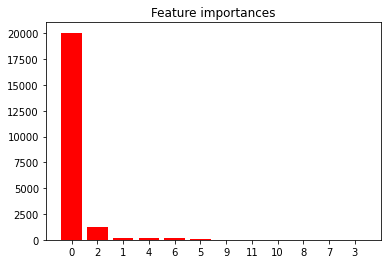

In [148]:
X, y = preprocess_for_FI(data)
feature_importances(X, y)

Vemos que, por mucha diferencia, la variable *indice_desarrollo_ciudad* es la variable más importante para el modelo. Esto pone de manifiesto que la decisión tomada en el notebook *Data_Exploration* era certera: entre las dos variables que hacen referencia a la ciudad (que son las que mayor correlación tienen con la variable objetivo), la que indica el índice de desarrollo aporta una información adicional que la hace más interesante. 

Y sabemos que vamos a eliminar la variable *ciudad*, pero por razones ilustrativas, de momento la vamos a mantener, y la que no vamos a mostrar es *indice_desarrollo_ciudad*, para tratar de mantener el resto de variables en un mismo orden de magnitud en cuanto a importancia y que sea más fácilmente interpretable la información.

Si ahora volvemos a comprobar lo mismo sin emplear dicha variable:

Feature ranking:
1. feature 1 (ciudad): 1227.794152
2. feature 0 (horas_formacion): 170.743027
3. feature 3 (experiencia_relevante): 163.755148
4. feature 5 (nivel_educacion): 135.684527
5. feature 4 (universidad_matriculado): 118.802049
6. feature 8 (tamano_compania): 25.929702
7. feature 10 (ultimo_nuevo_trabajo): 21.460701
8. feature 9 (tipo_compania): 18.804182
9. feature 7 (experiencia): 6.114468
10. feature 6 (educacion): 0.356147
11. feature 2 (genero): 0.069365


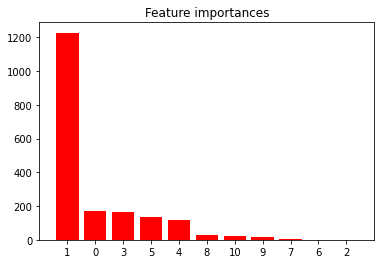

In [17]:
X, y = preprocess_for_FI(data.drop('indice_desarrollo_ciudad', axis=1))
feature_importances(X, y)

Las siguientes variables en orden de importancia son *horas_formacion* (la otra variable numérica), *experiencia_relevante*, *nivel_educacion* y *universidad_matriculado*. A excepción de *horas_formacion*, que tiene una correlación de 0 con la variable objetivo, las demás son las que mayor correlación presentan con la variable *target* (después de las variables de ciudad, claro). Sin embargo, sí se echa en falta otra variable que presenta una alta correlación con la variable objetivo, pero que sin embargo aquí no parece tener casi ningún tipo de impacto (*experiencia*). 

Además, las variables *educacion* y *genero* parecen no aportar ningún tipo de información relevante y, por tanto, se debe tomar alguna acción con ellas: pueden o bien eliminarse directamente, o bien emplearse para crear variables nuevas.

## 2. Creación de nuevas variables

Vamos a emplear las conclusiones obtenidas para tratar de generar nuevas features que aporten mayor calidad al conjunto de datos.

Antes de nada, vamos a rescatar la función *cramers_v* del notebook *Data_Exploration*, para medir la correlación de las nuevas variables.

In [7]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [8]:
data1 = data.copy()

### 2.1 Bucketización de la experiencia

Como hemos visto, la variable experiencia no aporta apenas info al modelo, pero sí hemos visto que es una de las variables que mayor correlación presenta con la variable *target*. Vamos por tanto a tratar de paquetizar su información, creando categorías que puedan ser relevantes. Por ejemplo, podemos probar a agrupar la experiencia en <1, <5, <10, <20 y >20

In [150]:
data1['experiencia_str'] = data1.experiencia.apply(lambda x: str(x))

In [151]:
np.unique(data1['experiencia_str'])

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '3', '4', '5', '6', '7', '8', '9', '<1', '>20', 'nan'],
      dtype=object)

In [26]:
def buckets_experiencia(x):
    try:
        x = int(x)
    
        # if x <= 3 or x == '<1':
        #     return '<3'
        # if x <= 5: 
        #     return '<5'
        if x <= 10:
            return '<10'
#         elif x >= 15:
#             return '<15'
        elif x <= 20:
            return '<20'
        # elif x > 15 or x == '>20':
        #   return '>15'
    except:
        if x == 'nan':
            return np.nan
        return x
        

In [27]:
data1['experiencia_str'] = data1.experiencia.apply(buckets_experiencia)

In [42]:
data.experiencia_str

0        >20
1        <20
2        <10
3         <1
4        >20
        ... 
19153    <20
19154    <20
19155    >20
19156     <1
19157    <10
Name: experiencia_str, Length: 19158, dtype: object

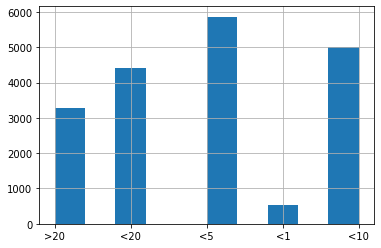

In [21]:
data1.experiencia_str.hist()

Vemos que se han generado buckets relativamente homogéneos en cuanto a cantidad de observaciones, a excepción del bucket *<1*, aunque a priori se puede pensar que es una categoría característica, ya que gente sinexperiencia puede no estar contenta en su primer trabajo y quiera buscar irse.

In [51]:
cramers_v(data1['target'], data1['experiencia_str'])

0.17695271938344684

En cuanto a correlación, vemos que no mejora frente a la variable original, aunque habrá que esperar a ver que pasa con la importancia.

### 2.2 Bucketización del tipo de compañía

Una de las cosas que se observan en esta variable, es que *Pvt Ltd* es el tipo preponderante, y el resto de compañías aparecen de manera casi residual. Por tanto, una de las opciones pasa por empaquetar todo el resto de compañías en la categoría *otros*:

In [24]:
data1['t_c'] = data1.tipo_compania.apply(lambda x: str(x))
np.unique(data1['t_c'])

array(['Early Stage Startup', 'Funded Startup', 'NGO', 'Other',
       'Public Sector', 'Pvt Ltd', 'nan'], dtype=object)

In [25]:
def buckets_tipo_compania(x):
    if x != 'nan' and x != 'Pvt Ltd':
        return 'Otros'
    elif x == 'nan':
        return np.nan
    return x
        

In [155]:
data1['t_c'] = data1['t_c'].apply(buckets_tipo_compania)

In [27]:
data1['t_c']

0            NaN
1        Pvt Ltd
2            NaN
3        Pvt Ltd
4          Otros
          ...   
19153        NaN
19154        NaN
19155    Pvt Ltd
19156    Pvt Ltd
19157        NaN
Name: t_c, Length: 19158, dtype: object

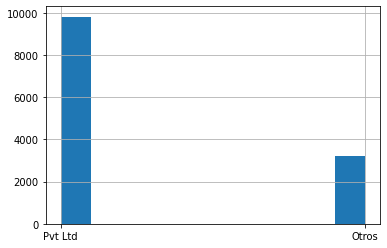

In [28]:
data1['t_c'].hist()

In [29]:
cramers_v(data1['t_c'], data['target'])

0.010129522319859611

En términos de correlación, vemos que disminuye bastante (de 0.048 a 0.01), por lo que no parece que esta empaquetización vaya a resultar muy efectiva.

### 2.3 Bucketización del tamaño de compañía

Hay 8 tipos de compañía diferente en función de su tamaño. Podemos agruparlas más, de modo que solo haya empresas pequeñas, medianas o grandes:

In [156]:
data1['tam_c'] = data1.tamano_compania.apply(lambda x: str(x))
# print(data['tam_c'].value_counts())
# np.unique(data['tam_c'])

0.053989227373892335


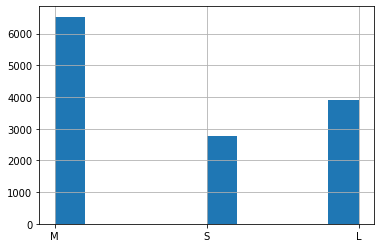

In [157]:
data1['tam_c'] = data1.tamano_compania.apply(lambda x: str(x))
def buckets_tam_compania(x):
    tam_c = {'<10': 'S', '10/49': 'S',
             '50-99': 'M', '100-500': 'M', 
             '500-999': 'M', '1000-4999': 'L', 
             '5000-9999': 'L', '10000+': 'L'}
    
    if x != 'nan':
        return tam_c[x]
    else:
        return np.nan
    

data1['tam_c'] = data1['tam_c'].apply(buckets_tam_compania)
data1['tam_c'].hist()
print(cramers_v(data1['tamano_compania'], data1['target']))

Vemos de nuevo que se tiene una correlación muy similar a la de la variable original. Esto puede ser bueno ya que aunque la variable nueva no mejore a la original, al menos se disminuye el número de variables para conseguir el mismo efecto.

### 2.4 Unión de experiencia con experiencia relevante

Una de las opciones que pueden ser interesantes es la de crear una nueva variable que combine la experiencia con la experiencia relevante. Esto significa que a partir de la variable experiencia *<10* años, surgirían dos variables: *<10 con experiencia relevante* y *<10 sin experiencia relevante*.

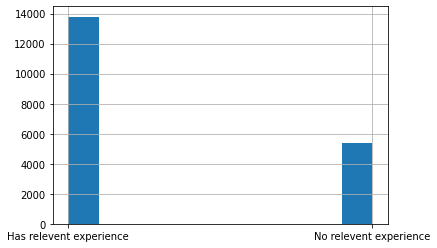

In [33]:
data1['experiencia_relevante'].hist()

In [239]:
# Función que combina buckets (combina dos columnas)
def combine_buckets(x1, x2):
    
    if str(x1) != 'nan' and str(x2) != 'nan':
        #Cogemos solo la primera palabra de cada variable para que no sea tan larga
        return str(x1).split(' ')[0] + '_' + str(x2).split(' ')[0] 
    else: 
        return np.nan
    return x1

In [28]:
data1['exp_rel-exp'] = data1.apply(lambda x: combine_buckets(x.experiencia_str, x.experiencia_relevante), axis=1)

In [29]:
data1['exp_rel-exp'].value_counts()

<10_Has    6855
<10_No     4019
<20_Has    3846
>20_Has    2883
<20_No      565
>20_No      403
<1_No       358
<1_Has      164
Name: exp_rel-exp, dtype: int64

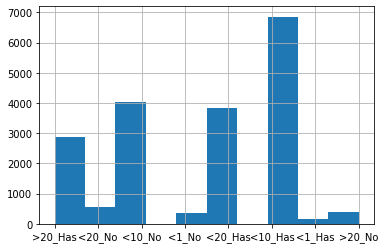

In [245]:
data1['exp_rel-exp'].hist()

In [246]:
cramers_v(data1['exp_rel-exp'], data1['target'])

0.18604545338685705

Vemos que esta variable sí mejora un poco a las otras dos individualmente en cuanto a correlación.

Antes de continuar extrayendo nuevas variables, vamos a comprobar de nuevo la feature importance de todas las variables, para ver si hemos conseguido algo o no:

Feature ranking:
1. feature 1 (ciudad): 1227.794152
2. feature 14 (exp_rel-exp): 487.588986
3. feature 0 (horas_formacion): 170.743027
4. feature 3 (experiencia_relevante): 163.755148
5. feature 5 (nivel_educacion): 135.684527
6. feature 11 (experiencia_str): 133.712616
7. feature 15 (uni_rel-exp): 124.111812
8. feature 4 (universidad_matriculado): 118.802049
9. feature 8 (tamano_compania): 25.929702
10. feature 10 (ultimo_nuevo_trabajo): 21.460701
11. feature 9 (tipo_compania): 18.804182
12. feature 12 (t_c): 8.872551
13. feature 7 (experiencia): 6.114468
14. feature 13 (tam_c): 3.189906
15. feature 6 (educacion): 0.356147
16. feature 2 (genero): 0.069365


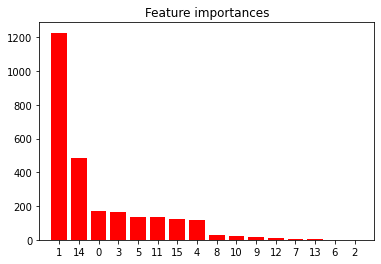

In [247]:
X, y = preprocess_for_FI(data1.drop(columns='indice_desarrollo_ciudad'))
feature_importances(X, y)

Como vemos, la nueva variable *exp-exp_rel*, que combina la experiencia con la experiencia relevante, tiene una importancia 5 veces superior a la de la variable *experiencia_relevante*. También el hecho de bucketizar la experiencia hace que esta sea mucho más importante. En este aspecto, cabe mencionar que si la experiencia se empaqueta en las categorías [<1, <5, <10, <20, >20], apenas se obtiene mejora, pero empaquetando en [<1, <10, <20, >20] se logra la mejora aquí mostrada. Esto nos hace ver que puede existir mucho juego, y que es importante elegir bien los límites para que el futuro modelo sea lo mejor posible. Haciendo varias pruebas, estas son las importancias que se han obtenido:

- [<1, <5, <10, <20, >20]: 44.23
- [<1, <10, <20, >20]: 807.26
- [<3, <10, <20, >20]: 206.52
- [<1, <8, <20, >20]: 810.58
- [<1, <5, <15, >15]: 755.66

Como vemos, el mejor resultado se obtiene con una categorización de la experiencia en [<1, <8, <20, >20].

Lo que mejores resultados ha dado hasta ahora ha sido la unión de dos variables. Vamos a seguir probando a hacer esto con otras variables, a ver que pasa:

### 2.5 Unión de experiencia relevante con universidad matriculado

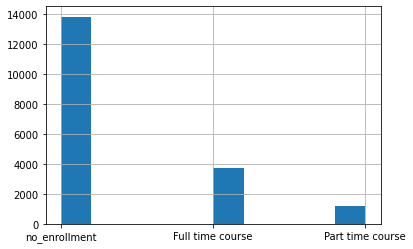

In [79]:
data1.universidad_matriculado.hist()

In [257]:
data1['uni_rel-exp'] = data1.apply(lambda x: combine_buckets(x.universidad_matriculado, x.experiencia_relevante), axis=1)
cramers_v(data1['uni_rel-exp'], data1['target'])

0.1738868260025442

### 2.6 Unión de experiencia con universidad matriculado

Del mismo modo que antes, vamos a probar a unir los años de experiencia con el hecho de estar matriculado en la universidad o no.

In [248]:
data1['exp_uni'] = data1.apply(lambda x: combine_buckets(x.experiencia_str, x.universidad_matriculado), axis=1)
cramers_v(data1['exp_uni'], data1['target'])

0.2002034843806971

### 2.7 Unión de experiencia, experiencia relevante y universidad matriculado

Vamos a probar ahora a dara un paso más, y unir las tres variables. De este modo, una opción sería tener menos de 10 años de experiencia, que dicha experiencia sea relevante y que además estés matriculado en la universidad a tiempo completo. 

La justificación de probar con esta variable es que puede ocurrir que si un persona tiene cierta experiencia, se apunte a un máster para mejorar sus conocimientos en cierta área y poder así pedir un ascenso o un cambio de trabajo.

In [249]:
data1['exp_rel-exp_uni'] = data1.apply(lambda x: combine_buckets(x.exp_uni, x.experiencia_relevante), axis=1)
cramers_v(data1['exp_rel-exp_uni'], data1['target'])

0.20796538759616454

Vamos a comprobar de nuevo las feature importances con estas tres nuevas variables.

Feature ranking:
1. feature 17 (exp_rel-exp_uni): 2150.284806
2. feature 1 (ciudad): 1227.794152
3. feature 16 (exp_uni): 1213.484369
4. feature 14 (exp_rel-exp): 487.588986
5. feature 0 (horas_formacion): 170.743027
6. feature 3 (experiencia_relevante): 163.755148
7. feature 5 (nivel_educacion): 135.684527
8. feature 11 (experiencia_str): 133.712616
9. feature 15 (uni_rel-exp): 124.111812
10. feature 4 (universidad_matriculado): 118.802049
11. feature 8 (tamano_compania): 25.929702
12. feature 10 (ultimo_nuevo_trabajo): 21.460701
13. feature 9 (tipo_compania): 18.804182
14. feature 12 (t_c): 8.872551
15. feature 7 (experiencia): 6.114468
16. feature 13 (tam_c): 3.189906
17. feature 6 (educacion): 0.356147
18. feature 2 (genero): 0.069365


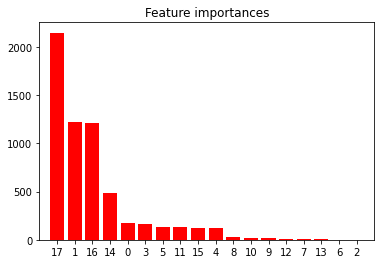

In [250]:
X, y = preprocess_for_FI(data1.drop(columns='indice_desarrollo_ciudad'))
feature_importances(X, y)

Se aprecia que esta última variable (combinación de experiencia con experiencia relevante y estar matriculado en la universidad, es la variable más importante ahora con una importancia de 2326.86. Además, la unión de experiencia con universidad también logra una muy buena variable, aunque la unión entre experiencia relevante y universidad matriculado no tanto.

### 2.8 Unión de tamaño de compañia con experiencia

In [258]:
data1['exp_tam'] = data1.apply(lambda x: combine_buckets(x.experiencia_str, x.tam_c), axis=1)
cramers_v(data1['target'], data1['exp_tam'])

0.1901662222985369

### 2.9 Unión tamaño de compañía con ultimo nuevo trabajo

In [254]:
data1['ult_tam'] = data1.apply(lambda x: combine_buckets(x.ultimo_nuevo_trabajo, x.tam_c), axis=1)

In [255]:
np.unique(data1['ult_tam'].apply(lambda x: str(x)))

array(['1_L', '1_M', '1_S', '2_L', '2_M', '2_S', '3_L', '3_M', '3_S',
       '4_L', '4_M', '4_S', '>4_L', '>4_M', '>4_S', 'nan', 'never_L',
       'never_M', 'never_S'], dtype=object)

Feature ranking:
1. feature 0 (indice_desarrollo_ciudad): 20049.376856
2. feature 18 (exp_rel-exp_uni): 2150.284806
3. feature 19 (exp_tam): 2124.030116
4. feature 20 (ult_tam): 1416.597109
5. feature 2 (ciudad): 1227.794152
6. feature 17 (exp_uni): 1213.484369
7. feature 15 (exp_rel-exp): 487.588986
8. feature 1 (horas_formacion): 170.743027
9. feature 4 (experiencia_relevante): 163.755148
10. feature 6 (nivel_educacion): 135.684527
11. feature 12 (experiencia_str): 133.712616
12. feature 16 (uni_rel-exp): 124.111812
13. feature 5 (universidad_matriculado): 118.802049
14. feature 9 (tamano_compania): 25.929702
15. feature 11 (ultimo_nuevo_trabajo): 21.460701
16. feature 10 (tipo_compania): 18.804182
17. feature 13 (t_c): 8.872551
18. feature 8 (experiencia): 6.114468
19. feature 14 (tam_c): 3.189906
20. feature 7 (educacion): 0.356147
21. feature 3 (genero): 0.069365


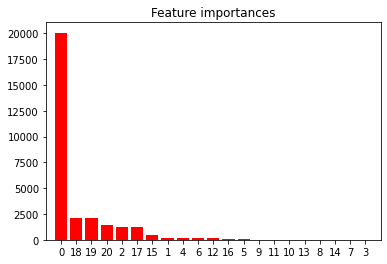

In [256]:
X, y = preprocess_for_FI(data1)
feature_importances(X, y)

### 2.10 Unión de último trabajo, tamaño compañía y universidad matriculado

In [105]:
data1['ult_tam_uni'] = data1.apply(lambda x: bucket_u_re(x.ult_tam, x.universidad_matriculado), axis=1)

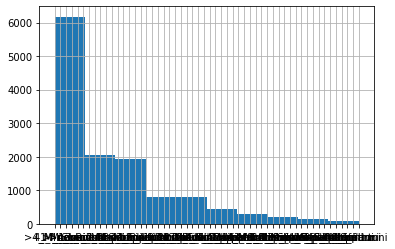

In [106]:
data1['ult_tam_uni'].hist()

### 2.11 Unión de buckets de id ciudad con nivel de educación

In [260]:
def id_ciudad(x):
    if x<0.5:
        return '<0.5'
    elif x<0.6:
        return '<0.6'
    elif x<0.7:
        return '<0.7'
    elif x<0.8:
        return '<0.8'
    elif x<0.9:
        return '<0.9'
    else:
        return '<1'

In [261]:
data1['id_ciudad'] = data1.indice_desarrollo_ciudad.apply(id_ciudad)
data1['ciudad_edu'] = data1.apply(lambda x: combine_buckets(x.id_ciudad, x.nivel_educacion), axis=1)

Feature ranking:
1. feature 0 (indice_desarrollo_ciudad): 20049.376856
2. feature 22 (ciudad_edu): 2857.829205
3. feature 18 (exp_rel-exp_uni): 2150.284806
4. feature 19 (exp_tam): 2124.030116
5. feature 20 (ult_tam): 1416.597109
6. feature 2 (ciudad): 1227.794152
7. feature 17 (exp_uni): 1213.484369
8. feature 21 (id_ciudad): 572.049366
9. feature 15 (exp_rel-exp): 487.588986
10. feature 1 (horas_formacion): 170.743027
11. feature 4 (experiencia_relevante): 163.755148
12. feature 6 (nivel_educacion): 135.684527
13. feature 12 (experiencia_str): 133.712616
14. feature 16 (uni_rel-exp): 124.111812
15. feature 5 (universidad_matriculado): 118.802049
16. feature 9 (tamano_compania): 25.929702
17. feature 11 (ultimo_nuevo_trabajo): 21.460701
18. feature 10 (tipo_compania): 18.804182
19. feature 13 (t_c): 8.872551
20. feature 8 (experiencia): 6.114468
21. feature 14 (tam_c): 3.189906
22. feature 7 (educacion): 0.356147
23. feature 3 (genero): 0.069365


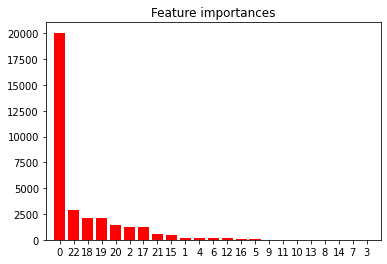

In [263]:
X, y = preprocess_for_FI(data1)
feature_importances(X, y)

Hemos encontrado ciertas variables que a priori deberían mejorar la efectividad del modelo. Estas son:
1. Nivel de educación por rango de índice de desarrollo de ciudad
2. Experiencia en función de la experiencia relevante y de si se está matriculado o no en la universidad
3. Experiencia en base al tamaño de la empresa
4. último cambio de trabajo en base al tamaño de la empresa.

Es interesante que el tamaño de la empresa por sí solo no importa información importante, pero si se combina con otras variables como el cambio de trabajo o la experiencia, esta sí juega un papel importante.

## 3. Feature engineering pipeline function

Vamos a organizar todo lo que hemos visto hasta ahora, de manera que sea automatizable en un pipeline de datos.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## Distintas funciones para la creación de cada feature
def buckets_experiencia(x, limits = [10, 20]):
    try:
        x = int(x)
        for i in limits:
            if x <= i:
                return '<' + str(i)
    except:
        if x == 'nan':
            return np.nan
        return x

def buckets_tam_compania(x):
    tam_c = {'<10': 'S', '10/49': 'S',
             '50-99': 'M', '100-500': 'M', 
             '500-999': 'M', '1000-4999': 'L', 
             '5000-9999': 'L', '10000+': 'L'}
    
    if x != 'nan':
        return tam_c[x]
    else:
        return np.nan

def combine_buckets(x1, x2):
    if str(x1) != 'nan' and str(x2) != 'nan':
        #Cogemos solo la primera palabra de cada variable para que no sea tan larga
        return str(x1).split(' ')[0] + '_' + str(x2).split(' ')[0] 
    else: 
        return np.nan
    return x1


def id_ciudad1(x, limits = [0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    for i in limits:
        if float(x) < i:
            return '<' + str(i)
    


def combine_features(data, col1, col2, new_col_name, f1=None, f2=None):
    """This function combines two features calling the combine_buckets function.
    Args:
    data (DataFrame): whole dataset
    col1 (str): name of the first column to combine
    col2 (str): name of the second column to combine
    new_col_name (str): name for the new variable
    f1 (str) optional: optional function to apply to the first column
    f2 (str) optional: optional function to apply to the second column
    
    Returns:
    data1 (DataFrame): new dataset with the new variable"""

    data1 = data.copy()
    # Convert all values of the variables into string
    data1['new_'+col1] = data1[col1].apply(lambda x: str(x))
    data1['new_'+col2] = data1[col2].apply(lambda x: str(x))

    # If there are prior functions to apply, do it 
    if f1 != None:
        data1['new_'+col1] = data1[col1].apply(f1)
    if f2 != None:
        data1['new_'+col2] = data1[col2].apply(f2)
    # Create new feature by combining variables
    data1[new_col_name] = data1.apply(lambda x: combine_buckets(x['new_'+col1], x['new_'+col2]), axis=1)
    # Delete the stringed variables
    data1.drop(columns=['new_'+col1, 'new_'+col2], inplace=True)
    return data1


# Clase encargada de crear nuevas features, llamando a la función correspondiente
class CreateFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, function, *args, **kwargs):
      self.function = function
      self.args = args
      self.kwargs = kwargs
  def fit(self, X, y=None):
      return self
  def transform(self, X):
      return self.function(X, *self.args, **self.kwargs)

# Clase encargada de eliminar features
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features = features_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.features)


In [61]:
data2 = combine_features(data1, col1='indice_desarrollo_ciudad', col2='nivel_educacion',
                         new_col_name='ciudad_edu', f1=id_ciudad1)

In [37]:
data2 = combine_features(data2, col1='experiencia', col2='experiencia_relevante',
                         new_col_name='exp_exp-rel', f1=buckets_experiencia)

In [58]:
df = DropFeatures(['ciudad', 'genero'])
data3 = df.fit_transform(data2)